# Perspective Projection: Distance Estimation

## Perceptron


## Neural Network


# Coding: Getting Started
Before you get started you need to follow the descriptions of the Git-Repository and make sure that all required packages are properly installed. It is recommended to work in a virtual environment. Start your virtual environment **before** you launch this jupyter-notebook. Then you may need to change the kernel: *Kernel &rarr; Change kernel &rarr; venv*

In [1]:
import torch
import cv2
import os 
import glob
import argparse
import data_setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mlp_utils as mlp_utils
import train_utils
from tqdm.auto import tqdm
from model import DistNet_MLP as mlp

/Users/piabideau/Documents/SCIoI/summer-school/tutorial/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
YOLO_MODEL = './model/yolo_model.pt'
FILE = '../../data/take0_17-05-34/2023-6-28_17-05-34-821/2023-6-28_17-06-35-343099.png'
PATH_TRAIN = '../../data/take0_17-05-34/train'
PATH_VAL = '../../data/take0_17-05-34/val'
PATH_TEST = '../../data/take1_17-14-44/2023-6-28_17-14-44-629'
PATH_MODEL_PRETRAINED = './model/mlp_model.pth'
PATH_MODEL_SAVE = './model/mlp_model_trained.pth'
PATH_CSV_TRAIN = '../../data/take0_17-05-34/take_2023-06-28_05-28-07_pm_clean_matched_robo-ordered.csv'
PATH_CSV_VAL = '../../data/take1_17-14-44/take_2023-06-28_05-34-07_pm_clean_matched_robo-ordered.csv'
ROBOTS = ["ollie", "grace", "alan", "hermann", "kaethe"]
CAM_ROBOT = "ollie"
MAX_DIST = 500
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
FILE_EXTENSION = "*.png"
ROBOT_HEIGHT_M = 0.09
FOCALLENGTH_PX = 528.695652
CONFIDENCE = 0.75
NUM_EPOCHS = 50
RELOAD_WEIGHTS = True
LR = 0.0001

In [12]:
# Loading YOLOv5 Model
model_YOLO = torch.hub.load('ultralytics/yolov5', 'custom', path=YOLO_MODEL, verbose=False)
model_YOLO.conf = CONFIDENCE
model_YOLO.to(DEVICE)

YOLOv5 🚀 2023-8-13 Python-3.11.4 torch-2.0.1 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

## Part 1.1: Training a small MLP (multi-layer perceptron)

The provided code automatically detects little Lego Robots in an image. For detection we use a fine-tuned YOLOv5 network that estimates bounding boxes, that each capture the rough dimensions of the projected object.
Given the height of an object bounding box, the camera's focal length as well as the actual robot's height we compute the absolut distance between "CAM_ROBOT" and all visible robots in the image.

In [13]:
# Load the training and validation image sets.
file_pattern = os.path.join(PATH_TRAIN, FILE_EXTENSION)
train_images = glob.glob(file_pattern)

file_pattern = os.path.join(PATH_VAL, FILE_EXTENSION)
valid_images = glob.glob(file_pattern)

# Pass images through yolo and get bounding boxes with their corresponding csv distance labels
train_data = mlp_utils.images2data(model_YOLO, train_images, PATH_CSV_TRAIN, verbose = False)
valid_data = mlp_utils.images2data(model_YOLO, valid_images, PATH_CSV_VAL, verbose = False)

In [14]:
# Load the MLP model
model_MLP = mlp.MLP()

# reloads weights if continue training from already trained model is desired 
# else initalize weights as random
#if RELOAD_WEIGHTS is True:
#    print("...continue training with pretained weights!")
#    model_MLP.load_state_dict(torch.load(PATH_MODEL_PRETRAINED, map_location=torch.device(DEVICE)))

# Define optimizer
optimizer = torch.optim.Adam(params=model_MLP.parameters(), lr=LR)
loss_fn = torch.nn.MSELoss()

# Pass the data through the dataloader
train_dataloader, valid_dataloader = data_setup.create_dataloader(train_data, valid_data, batch_size=5)
train_features_batch, train_labels_batch = next(iter(train_dataloader))

  6%|██████▋                                                                                                         | 3/50 [00:00<00:04, 10.95it/s]

Epoch: 0
------
Train loss: 0.09395



 26%|████████████████████████████▊                                                                                  | 13/50 [00:01<00:03, 12.12it/s]

Epoch: 10
------
Train loss: 0.00996



 46%|███████████████████████████████████████████████████                                                            | 23/50 [00:01<00:02, 12.22it/s]

Epoch: 20
------
Train loss: 0.00185



 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 33/50 [00:02<00:01, 12.32it/s]

Epoch: 30
------
Train loss: 0.00144



 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 43/50 [00:03<00:00, 12.06it/s]

Epoch: 40
------
Train loss: 0.00120



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 12.05it/s]


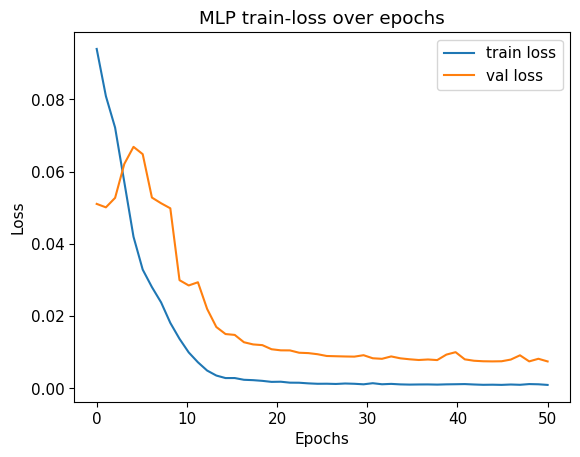

In [15]:
# Set training
best_metric = float('inf')  # Initialize with a large value for loss
train_loss_plotting = []
validation_loss_plotting = []

# Training Loop
for epoch in tqdm(range(NUM_EPOCHS)):
    train_loss = train_utils.train_step(model_MLP, train_dataloader, loss_fn, optimizer, DEVICE)
    validation_loss = train_utils.validation_step(model_MLP, valid_dataloader, loss_fn, DEVICE)

    # add train loss fro plotting
    train_loss_plotting.append(train_loss.item())
    validation_loss_plotting.append(validation_loss.item())
  
    if validation_loss < best_metric:
        best_metric = validation_loss
        torch.save(model_MLP.state_dict(), PATH_MODEL_SAVE)

    if(epoch % 10 == 0):
        print(f"Epoch: {epoch}\n------")
        print(f"Train loss: {train_loss:.5f}\n")
        
# plotting stuff
%matplotlib inline
x_err = np.linspace(0, NUM_EPOCHS, NUM_EPOCHS)
plt.plot(x_err, train_loss_plotting, label='train loss')
plt.plot(x_err, validation_loss_plotting, label='val loss')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MLP train-loss over epochs')

# Display the plot
plt.legend()

plt.show()

### Question: 
Can you overfit intentionally to the training data? How does the validation curve will look like? Please verify your assumption.

## Part 1.2: Inference on a single image

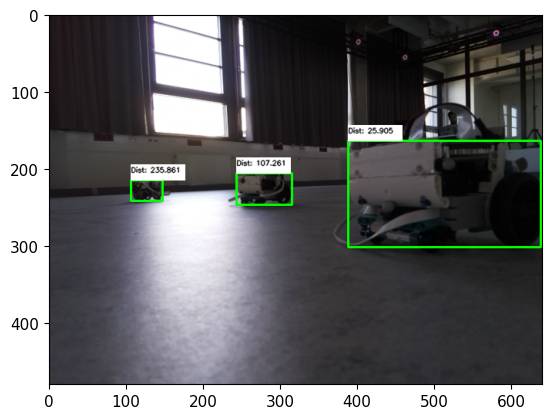

In [16]:
# loading trained model
model = mlp.MLP()
model.load_state_dict(torch.load(PATH_MODEL_SAVE, map_location=torch.device(DEVICE)))
model.eval() 

# yolo bounding box detection
res = model_YOLO(FILE)

bounding_boxes = res.xyxy[0][res.xyxy[0][:, 0].sort()[1]]
image = cv2.imread(FILE)

for box in bounding_boxes:
    
    BBH = (box[3] - box[1]) / 640
    BBW = (box[2] - box[0]) / (640)
    BBCenter = torch.tensor([(box[2] + box[0]) / 2 , (box[3] + box[1]) / 2 ], dtype = torch.float32, device = DEVICE) / 640
    BBAspectRatio = BBW / BBH / 6
    BBClass = box[5]
    BBConf = box[4]
    BBArea = BBH * BBW
    BBAreaCover = (BBArea)
    params = torch.stack((torch.tensor(1).to(DEVICE), torch.tensor(1).to(DEVICE), BBH, BBW, BBAspectRatio, BBClass, BBConf, BBArea, BBAreaCover))
    input = torch.cat((params, BBCenter), 0)
    distance = model(input)
    
    cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)
    image_with_rectangle = cv2.rectangle(image, (int(box[0]), int(box[1])-20), (int(box[0]) + 70, int(box[1])), (255,255,255), -1)
    img_drawn = cv2.putText(image, f"Dist: {(distance.item() * MAX_DIST):.3f}", (int(box[0]), int(box[1] - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0,0,0), 1, cv2.LINE_AA)
    image_rgb = cv2.cvtColor(img_drawn, cv2.COLOR_BGR2RGB)


# visualize frame with overlayed 
# bounding boxes and distance estimates
%matplotlib inline

fig = plt.figure()
plt.imshow(image_rgb)
plt.show()

## Part 1.3: Visualization

... now let's run this code on several consequtive frames and visualize the relationship between object height and its distance.

In [22]:
print("Loading Pictures...")

file_pattern = os.path.join(PATH_TEST, FILE_EXTENSION)
picture_files = glob.glob(file_pattern)
picture_files.sort()

print("Reading pictures...")

values = {}

first_image = cv2.imread(picture_files[0])
height, width, _ = first_image.shape

for i, file in enumerate(picture_files):

    res = model_YOLO(file)
    bounding_boxes = res.xyxy[0][res.xyxy[0][:, 0].sort()[1]]

    for box in bounding_boxes:
        BBH = (box[3] - box[1]) / 640
        BBW = (box[2] - box[0]) / 640

        BBCenter = torch.tensor([(box[2] + box[0]) / 2, (box[3] + box[1]) / 2 ], dtype = torch.float32, device = DEVICE) / 640
        BBAspectRatio = BBW / BBH / 6
        BBClass = box[5]
        BBConf = box[4]
        BBArea = BBH * BBW
        BBAreaCover = (BBArea)
        params = torch.stack((torch.tensor(1).to(DEVICE), torch.tensor(1).to(DEVICE), BBH, BBW, BBAspectRatio, BBClass, BBConf, BBArea, BBAreaCover))
        input = torch.cat((params, BBCenter), 0)
        distance = model(input)
        
        values.setdefault(distance, []).append(box[3] - box[1])



Loading Pictures...
Reading pictures...


In [ ]:
x = []
y = []

for dist in values:
    for height in values[dist]:
        x.append(height.item())
        y.append(dist.detach().numpy())

plt.scatter(x, y)

plt.xlabel('Height of the bounding box (in pixel)')
plt.ylabel('Distance (CMs)')
plt.title('Plot of height and distance')

plt.show()

## Part 2.1: Evaluation

Groudtruth robot poses were captured with a motion capture system for all robots visible in this data. Poses were saved in the provided .csv file. In this part of the tutorial let's anayse the observed error. How does this relate to the object's distance? What are possible causes of this error?

In [8]:
# get list of picture files in PATH
file_pattern = os.path.join(PATH, FILE_EXTENSION)
picture_files = glob.glob(file_pattern)
picture_files.sort()

# read csv file with ground truth robot poses
df = pd.read_csv(PATH_CSV, header=None)

# get column for each robot in csv file
row = df.iloc[0].to_numpy()
robot_col = {}
for rbo in ROBOTS:
    bool_array = row == rbo
    robot_col[rbo] = bool_array.argmax()
cam_robot_col = robot_col[CAM_ROBOT]

err = []
distance_x = []

for i, file in enumerate(picture_files):

    # -----------------------------------------------------------------
    # LOAD GROUNDTRUTH DISTANCES FOR EACH PICTURE
    # -----------------------------------------------------------------
    
    row_val = os.path.basename(file)
    row_matching_value = df[df.iloc[:, 0] == row_val]
    print("********")
    print(row_val)

    if row_matching_value.empty:
        print("Skipping, since no matching image name in csv")
        continue

    row = row_matching_value.index[0]

    if type(df.at[row,2]) is not str and math.isnan(df.at[row,2]):
        print("Skipping, since no robots visable on image ")
        continue
       
    # robots present in current frame
    robot_list = df.at[row,2].split()
    
    distance_gt = []
    
    for robot in zip(robot_list):
        
        # pose of the camera robot
        camX = df.at[row,cam_robot_col+2]
        camY = df.at[row,cam_robot_col]

        # pose of neighboring robot
        robotX = df.at[row, robot_col[robot[0]] + 2]
        robotY = df.at[row, robot_col[robot[0]]]

        # GROUNDTRUTH DISTANCE
        distance = np.sqrt((float(robotX)-float(camX)) ** 2 + (float(robotY)-float(camY)) ** 2)
        distance = distance / 100
        
        print(f"distance_gt: {distance}")
        
        distance = torch.tensor(distance, dtype = torch.float32,)
        distance_gt.append(distance)
        
    # -----------------------------------------------------------------
    # COMPUTE DISTANCE FROM BOUNDING BOX HEIGHT
    # -----------------------------------------------------------------
    
    res = model_YOLO(file)
    bounding_boxes = res.xyxy[0][res.xyxy[0][:, 0].sort()[1]]

    distance_estim = []
    
    for box in bounding_boxes:
        
        bbh = box[3] - box[1]
        distance = FOCALLENGTH_PX * ROBOT_HEIGHT_M / bbh
        distance_estim.append(distance)
        
        print(f"distance_estim: {distance}")
        
    # -----------------------------------------------------------------
    # COMPUTE ERROR
    # -----------------------------------------------------------------
    
    if(bounding_boxes.shape[0] == len(robot_list)):

        error = abs(np.array(distance_gt) - np.array(distance_estim))
        err.extend(error)
        distance_x.extend(distance_gt)

********
2023-6-28_17-05-35-594747.png
Skipping, since no matching image name in csv
********
2023-6-28_17-05-35-712397.png
Skipping, since no matching image name in csv
********
2023-6-28_17-05-35-764330.png
Skipping, since no matching image name in csv
********
2023-6-28_17-05-38-982314.png
distance_gt: 4.642136309325211
distance_gt: 3.8728825015836748
distance_gt: 4.401366339645449
distance_estim: 4.156468391418457
distance_estim: 3.6044561862945557
distance_estim: 4.492337226867676
********
2023-6-28_17-05-39-036497.png
distance_gt: 4.642094755589334
distance_gt: 3.8728830556334986
distance_gt: 4.401352834300173
distance_estim: 4.151609897613525
distance_estim: 3.6144917011260986
distance_estim: 4.4780802726745605
********
2023-6-28_17-05-39-086685.png
distance_gt: 4.6421464025204555
distance_gt: 3.8728951274607395
distance_gt: 4.401374359261215
distance_estim: 4.157343864440918
distance_estim: 3.6052815914154053
distance_estim: 4.486623287200928
********
2023-6-28_17-05-39-141069.

distance_estim: 4.15524959564209
distance_estim: 3.6089282035827637
distance_estim: 4.493748664855957
********
2023-6-28_17-05-40-761605.png
distance_gt: 4.642142189171834
distance_gt: 3.8729196744967727
distance_gt: 4.4014020794235345
distance_estim: 4.174943447113037
distance_estim: 3.603956460952759
distance_estim: 4.479547023773193
distance_estim: 0.47847896814346313
********
2023-6-28_17-05-40-803024.png
distance_gt: 4.642105448519007
distance_gt: 3.872899091724889
distance_gt: 4.40137691599442
distance_estim: 4.16273832321167
distance_estim: 3.6178548336029053
distance_estim: 4.468813419342041
distance_estim: 0.4964524507522583
********
2023-6-28_17-05-40-844906.png
distance_gt: 4.6421327669174
distance_gt: 3.8728845224601387
distance_gt: 4.4013729293840695
distance_estim: 4.175670146942139
distance_estim: 3.6048812866210938
distance_estim: 4.478529930114746
distance_estim: 0.4777962863445282
********
2023-6-28_17-05-40-886167.png
distance_gt: 4.642110845371552
distance_gt: 3.872

distance_estim: 4.172228813171387
distance_estim: 3.5765185356140137
distance_estim: 3.6586804389953613
distance_estim: 1.2884914875030518
********
2023-6-28_17-05-44-206050.png
distance_gt: 4.642142841398921
distance_gt: 3.872890428843227
distance_gt: 4.401378314171133
distance_gt: 1.2554925912256936
distance_estim: 4.178411960601807
distance_estim: 3.5881073474884033
distance_estim: 3.6660611629486084
distance_estim: 1.2901889085769653
********
2023-6-28_17-05-44-263834.png
distance_gt: 4.6420911997317775
distance_gt: 3.872857157069277
distance_gt: 4.401332974364464
distance_gt: 1.255318737676776
distance_estim: 4.176508903503418
distance_estim: 3.570965051651001
distance_estim: 3.6507818698883057
distance_estim: 1.2890594005584717
********
2023-6-28_17-05-44-320589.png
distance_gt: 4.6421401097667765
distance_gt: 3.872919624650325
distance_gt: 4.40138537831885
distance_gt: 1.2559541579608053
distance_estim: 4.161971569061279
distance_estim: 3.5766170024871826
distance_estim: 3.66649

distance_estim: 1.6873385906219482
distance_estim: 4.132946014404297
distance_estim: 3.586118459701538
distance_estim: 4.496755123138428
********
2023-6-28_17-05-49-805894.png
distance_gt: 1.969982893200028
distance_gt: 4.642071870985692
distance_gt: 3.87285251293121
distance_gt: 4.401327819865143
distance_estim: 1.6938514709472656
distance_estim: 4.113830089569092
distance_estim: 3.581653356552124
distance_estim: 4.491198539733887
********
2023-6-28_17-05-49-849522.png
distance_gt: 1.9774409781853022
distance_gt: 4.642099819433779
distance_gt: 3.872868124703336
distance_gt: 4.4013568654616835
distance_estim: 1.693244457244873
distance_estim: 4.115991115570068
distance_estim: 3.586184501647949
distance_estim: 4.498831272125244
********
2023-6-28_17-05-49-898920.png
distance_gt: 1.9806175917891715
distance_gt: 4.642118945628401
distance_gt: 3.872876260617664
distance_gt: 4.401361963572333
distance_estim: 1.695000410079956
distance_estim: 4.120755672454834
distance_estim: 3.5813903808593

distance_estim: 0.5559847354888916
********
2023-6-28_17-06-25-329837.png
distance_gt: 0.7321362479272422
distance_estim: 0.5506349802017212
********
2023-6-28_17-06-25-381067.png
distance_gt: 0.7181601345542395
distance_estim: 0.5231074094772339
********
2023-6-28_17-06-29-524263.png
distance_gt: 1.3642972226495136
distance_gt: 0.5941307746213084
distance_estim: 1.3486515283584595
distance_estim: 0.5767285823822021
********
2023-6-28_17-06-29-572828.png
distance_gt: 1.3703213940076393
distance_gt: 0.5981541652582824
distance_estim: 1.349965214729309
distance_estim: 0.5766457319259644
********
2023-6-28_17-06-29-622542.png
Skipping, since no matching image name in csv
********
2023-6-28_17-06-29-678911.png
Skipping, since no matching image name in csv
********
2023-6-28_17-06-29-735763.png
Skipping, since no matching image name in csv
********
2023-6-28_17-06-29-790833.png
Skipping, since no matching image name in csv
********
2023-6-28_17-06-29-834167.png
Skipping, since no matching i

## Part 2.2: Visualization
...now let's visualize again.

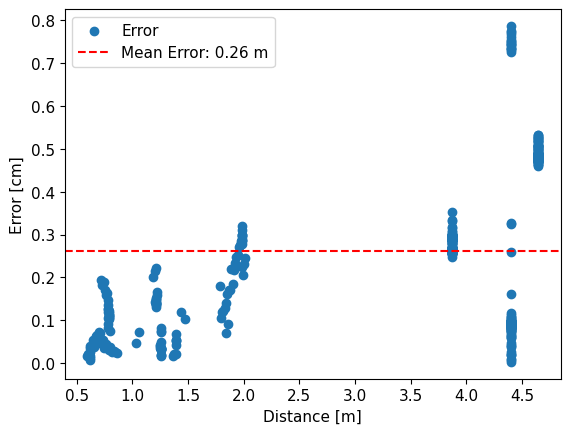

In [9]:
plt.scatter(distance_x, err, label='Error')
mean_err = np.mean(err)
plt.axhline(y=mean_err, color='r', linestyle='--', label=f'Mean Error: {mean_err:.2f} m')

# Adding labels and title
plt.xlabel('Distance [m]')
plt.ylabel('Error [cm]')

# Display the plot
plt.legend()
plt.show(block=True)

## Question 1:
Please describe the behavior of the error. What are possible causes for errors that you observe? (Please name at least three causes)

*Answer:*